In [1]:
import numpy as np
import pandas as pd
import odbo

## Data loading and adapt search space

In [2]:
threshold = 0.05
data_train = pd.read_csv('../datasets/GB1_2016_384.csv', sep=',')
np.random.seed(0)

#load data
name_pre, Y_train = np.array(data_train['AACombo']), np.array(data_train['Fitness'])
name = odbo.utils.code_to_array(name_pre)

# Using average measurement results as features
feature_model = odbo.featurization.AvgMeasurement(raw_vars=name, Y=Y_train)
X_train = feature_model.transform(name)

# Find the adaptive search space model
labels_train = odbo.prescreening.sp_label(X_train, Y_train, thres=threshold)
pre_model = odbo.prescreening.XGBOD(eval_metric = 'error')
pre_model.fit(X_train, labels_train)
pred_labels = pre_model.predict(X_train)

/usr/local/lib/python3.7/site-packages/pyod/models/base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")
/usr/local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:19:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [3]:
# Predict the adaptive search space of the problem
data_test = pd.read_csv('../datasets/GB1_2016_149361.csv', sep=',')
name_pre, Y_test = np.array(data_test['AACombo']), np.array(data_test['Fitness'])
name = odbo.utils.code_to_array(name_pre)
X_test = feature_model.transform(name)
labels_test = odbo.prescreening.sp_label(X_test, Y_test, thres=0.05)
pred_test_labels = pre_model.predict(X_test)


Correct ratio: 92.388%
FN ratio: 5.739%
FP ratio: 1.873%


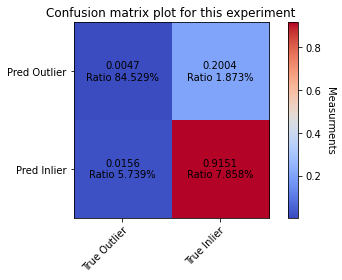

In [4]:
# Plot the confusion matrix to check the accuracy of search space prescreening
out_outlier, in_outlier, out_inlier, in_inlier = odbo.plot.plot_cm(labels_test, pred_test_labels, Y_test)
print("Correct ratio: {0:.3%}".format((len(out_outlier)+len(in_inlier))/len(labels_test)))
print("FN ratio: {0:.3%}".format(len(out_inlier)/len(labels_test)))
print("FP ratio: {0:.3%}".format(len(in_outlier)/len(labels_test)))  


## BO for next best experiment

In [24]:
import torch
# Pick the Top 40 init experiment from the 384 experiments
sele_id = np.argsort(Y_train)[-40:]
X_train_sele, Y_train_sele = torch.tensor(X_train[sele_id, :]), torch.tensor(Y_train[sele_id].reshape(40,1))
# Only search the space after prescreening
sele_id_test = []
sele_id_test.extend(in_inlier)
sele_id_test.extend(out_inlier)
print(len(sele_id_test))
X_test_sele, Y_test_sele = torch.tensor(X_test[sele_id_test, :]), torch.tensor(Y_test[sele_id_test].reshape(len(sele_id_test),1))
print(X_train_sele.shape, Y_train_sele.shape, X_test_sele.shape, Y_test_sele.shape)


20309
torch.Size([40, 4]) torch.Size([40, 1]) torch.Size([20309, 4]) torch.Size([20309, 1])


In [22]:
from botorch.fit import fit_gpytorch_model
from botorch.optim.fit import fit_gpytorch_torch, fit_gpytorch_scipy
import gpytorch
def GPRegression(X,
                 Y,
                 likelihood = None,
                 noise_constraint=gpytorch.constraints.Interval(1e-6, 1e-2),
                 min_inferred_noise_level=1e-4,
                 **kwargs):
    from gpytorch.mlls import ExactMarginalLogLikelihood
    from gpytorch.likelihoods import GaussianLikelihood
    from botorch.fit import fit_gpytorch_model
    model = odbo.gp.GP(
        X,
        Y,
        likelihood=likelihood,
        min_inferred_noise_level=min_inferred_noise_level,
        **kwargs)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    mll.train()
    fit_gpytorch_torch(mll, options={'maxiter': 500})
    mll.eval()     
    return model

In [23]:
## Will move to a function in the source code
import botorch
import torch
import botorch.acquisition as acqf
from gpytorch.utils.errors import NanError, NotPSDError

method = 'BO'
search_iter = 50
batch_size = 1
bo_method = 'BO'
gp_method = 'singletask'
verbose = False
min_inferred_noise_level = 1e-4

if bo_method == 'BO' and gp_method == 'singletask':
    l = 0
    while l < search_iter:
        print("Iter: ", l, "Current Max: ", Y_train_sele.max().detach().numpy())
        X_train_sele_norm, Y_train_sele_norm, X_test_sele_norm, stats = odbo.utils.normalize_data(X_train_sele, 
                                                                           Y_train_sele, X_pending=X_test_sele)
        while True:
            try:
                gp_model = odbo.regressions.GPRegression(X_train_sele_norm, Y_train_sele_norm, min_inferred_noise_level = min_inferred_noise_level)
                break
            except NotPSDError:
#                gp_model = odbo.regressions.GPRegression(X_train_sele_norm, Y_train_sele_norm, min_inferred_noise_level = min_inferred_noise_level*10, optimizer = 'fit_gpytorch_torch')
                gp_model = GPRegression(X_train_sele_norm, Y_train_sele_norm, min_inferred_noise_level = min_inferred_noise_level)
                print('The scipy optimizer and minimum inferred noises cannot make the kernel PSD, switch to torch optimizer')
                break


        X_next, acq_value = odbo.bo.generate_batch(model = gp_model, X=X_train_sele_norm, 
                                               Y=Y_train_sele_norm, batch_size=batch_size,
                                               X_pending=X_test_sele_norm)
        ids_keep = []
        for i in range(len(Y_test_sele)):
            if torch.equal(X_next.detach(), X_test_sele_norm[i:i+1, :].detach()):
                next_exp_id = i
                if verbose == True:
                    print("Next experiment to pick: ", X_test_sele[i,:].detach().numpy(), "Acqusition value: ", acq_value.detach().numpy())
                    print("Newly added value: ", Y_test_sele[i].detach().numpy())
            else:
                ids_keep.append(i)
        X_train_sele, Y_train_sele = torch.cat([X_train_sele, X_test_sele[next_exp_id:next_exp_id+1, :]]), torch.cat([Y_train_sele, Y_test_sele[next_exp_id:next_exp_id+1]])
        X_test_sele, Y_test_sele = X_test_sele[ids_keep, :], Y_test_sele[ids_keep]
        l = l + 1


Iter:  0 Current Max:  2.9791068
Iter:  1 Current Max:  2.9791068
Iter:  2 Current Max:  3.566115248
Iter:  3 Current Max:  3.566115248
Iter:  4 Current Max:  5.360053561
Iter:  5 Current Max:  5.618708364
Iter 10/500: 1.630288707177583
Iter 20/500: 1.5357340239157315


/usr/local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Iter 30/500: 1.4373630136584679
Iter 40/500: 1.3249779206681846
Iter 50/500: 1.2952652805280362
Iter 60/500: 1.251788480765303
Iter:  6 Current Max:  5.618708364
Iter:  7 Current Max:  5.618708364
Iter:  8 Current Max:  5.618708364
Iter:  9 Current Max:  5.618708364
Iter:  10 Current Max:  6.044237145
Iter:  11 Current Max:  6.044237145
Iter:  12 Current Max:  6.044237145
Iter:  13 Current Max:  6.044237145
Iter:  14 Current Max:  6.044237145
Iter:  15 Current Max:  6.044237145
Iter:  16 Current Max:  6.044237145
Iter:  17 Current Max:  6.044237145
Iter:  18 Current Max:  6.044237145
Iter:  19 Current Max:  6.044237145
Iter:  20 Current Max:  6.044237145
Iter:  21 Current Max:  6.044237145
Iter:  22 Current Max:  6.044237145
Iter:  23 Current Max:  6.044237145
Iter:  24 Current Max:  6.044237145
Iter:  25 Current Max:  6.044237145
Iter:  26 Current Max:  6.044237145
Iter:  27 Current Max:  6.044237145
Iter:  28 Current Max:  6.044237145
Iter:  29 Current Max:  6.044237145
Iter:  30 Cur

KeyboardInterrupt: 